# 1D harmonic oscillator physics-informed neural network (PINN)

The example problem we solve here is the 1D damped harmonic oscillator:
$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~
$$
with the initial conditions
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~
$$
We will focus on solving the problem for the under-damped state, i.e. when 
$$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~
$$
This has the following exact solution:
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~
$$


## Workflow overview

>First we will train a standard neural network to interpolate a small part of the solution, using some observed training points from the solution.

>Next, we will train a PINN to extrapolate the full solution outside of these training points by penalising the underlying differential equation in its loss function.


## MLP PINN

100%|██████████| 100000/100000 [00:34<00:00, 2910.24it/s, Loss=0.0009010035]


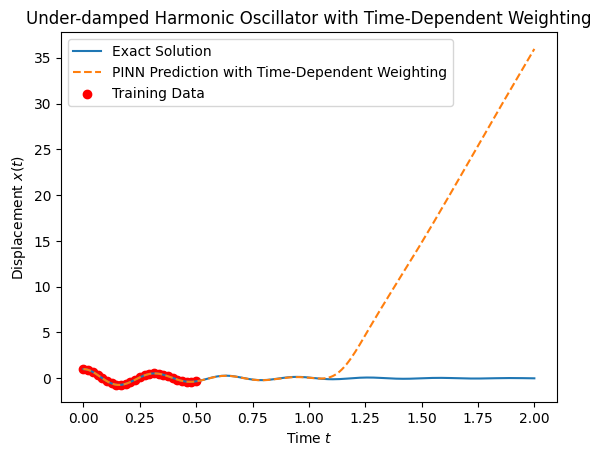

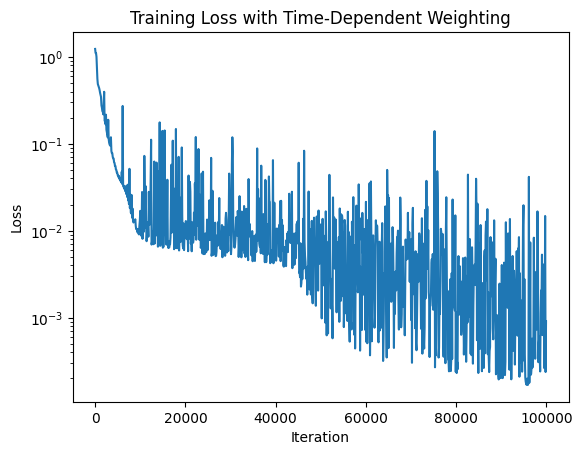

In [1]:
import numpy as np  # Original NumPy
import jax
import jax.numpy as jnp
from jax import random, grad, vmap, jit, value_and_grad
from jax.example_libraries import optimizers
from jax.flatten_util import ravel_pytree
from functools import partial
import matplotlib.pyplot as plt
from tqdm import trange
import itertools

# Define the exact solution of the underdamped harmonic oscillator
def oscillator(d, w0, t):
    w = jnp.sqrt(w0 ** 2 - d ** 2)
    phi = jnp.arctan(-d / w)
    A = 1.0 / (2.0 * jnp.cos(phi))
    cos_term = jnp.cos(phi + w * t)
    exp_term = jnp.exp(-d * t)
    x = exp_term * 2 * A * cos_term
    return x

# Define the MLP function
def MLP(layers, activation=jnp.tanh):
    def init(rng_key):
        def init_layer(key, d_in, d_out):
            k1, _ = random.split(key)
            glorot_stddev = 1.0 / jnp.sqrt((d_in + d_out) / 2.)
            W = glorot_stddev * random.normal(k1, (d_in, d_out))
            b = jnp.zeros(d_out)
            return W, b
        keys = random.split(rng_key, len(layers))
        params = list(map(init_layer, keys, layers[:-1], layers[1:]))
        return params

    def apply(params, ijnputs):
        H = ijnputs
        for W, b in params[:-1]:
            outputs = jnp.dot(H, W) + b
            H = activation(outputs)
        W, b = params[-1]
        outputs = jnp.dot(H, W) + b
        return outputs

    return init, apply

# Define the PINN model class with time-dependent weighting
class PINN:
    def __init__(self, key, layers, mu, k, act=jnp.tanh):

        # Initialize the neural network
        self.init, self.apply = MLP(layers, activation=act)
        params = self.init(rng_key=key)
        _, self.unravel = ravel_pytree(params)

        # Use optimizers to set optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=5000, decay_rate=0.9999999999)
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params)

        # Logger
        self.itercount = itertools.count()

        self.loss_log = []

        # Constants
        self.mu = mu
        self.k = k

        # Decay rate for time-dependent weighting
        self.lambda_decay = 1.0  # You can adjust this value

    def neural_net(self, params):
        def net_apply(t):
            outputs = self.apply(params, t.reshape(-1, 1))
            return outputs.squeeze()  # Ensure output is a scalar
        return net_apply

    def residual_net(self, params):
        net_apply = self.neural_net(params)
        def res_apply(t):
            x = net_apply(t)
            x_t = grad(net_apply)(t)
            x_tt = grad(grad(net_apply))(t)
            residual = x_tt + self.mu * x_t + self.k * x
            return residual
        return res_apply

    @partial(jit, static_argnums=(0,))
    def loss(self, params, t_r, t_data, x_data):
        # Residual loss with time-dependent weighting
        res_apply = self.residual_net(params)
        residual_fn = vmap(res_apply)
        res = residual_fn(t_r)
        res_squared = res ** 2

        # Time-dependent weights
        # Compute weights: w(t) = exp(-lambda * t)
        weights_time = jnp.exp(-self.lambda_decay * t_r)
        weights_time /= jnp.sum(weights_time)  # Normalize weights

         # If you want to use only time-dependent weights:
        weights = weights_time

        # Normalize combined weights
        weights /= jnp.sum(weights)

        # Apply weights to residual loss
        loss_res = jnp.sum(weights * res_squared)

        # Data loss (at observed data points)
        net_apply = self.neural_net(params)
        x_pred = vmap(net_apply)(t_data)
        loss_data = jnp.mean((x_pred - x_data) ** 2)

        # Initial condition loss
        x0_pred = net_apply(jnp.array(0.0))
        x0_t_pred = grad(net_apply)(jnp.array(0.0))
        loss_ic = (x0_pred - 1.0) ** 2 + (x0_t_pred - 0.0) ** 2

        # Total loss
        total_loss = 1.e-4*loss_res + loss_data + loss_ic

        return total_loss

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, t_r, t_data, x_data):
        params = self.get_params(opt_state)
        value, grads = value_and_grad(self.loss)(params, t_r, t_data, x_data)
        opt_state = self.opt_update(i, grads, opt_state)
        return opt_state, value

    def train(self, nIter, t_r, t_data, x_data):
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            self.current_count = next(self.itercount)
            self.opt_state, loss_value = self.step(self.current_count, self.opt_state, t_r, t_data, x_data)

            if it % 100 == 0:
                self.loss_log.append(loss_value)
                pbar.set_postfix({'Loss': loss_value})

# Constants for the underdamped harmonic oscillator
d = 2.0
w0 = 20.0
mu = 2 * d
k = w0 ** 2

# Generate collocation points and data points
t_r = jnp.linspace(0.0, 1.0, 100)          # Collocation points for residual
t_data = jnp.linspace(0.0, 0.5, 25)        # Data points for initial training
x_data = oscillator(d, w0, t_data)        # Exact solution at data points

# Initialize the model
key = random.PRNGKey(0)
layers = [1, 4096, 32, 1]
model = PINN(key, layers, mu, k, act=jax.nn.gelu)

# Convert data to appropriate types
t_r = jnp.array(t_r)
t_data = jnp.array(t_data)
x_data = jnp.array(x_data)

# Adjust the decay rate as needed
model.lambda_decay = 1.0  # You can experiment with different values

# Train the model
model.train(nIter=100000, t_r=t_r, t_data=t_data, x_data=x_data)

# Evaluate the model
params = model.get_params(model.opt_state)
t_test = jnp.linspace(0.0, 2.0, 200)
t_test = jnp.array(t_test)
net_apply = model.neural_net(params)
x_pred = vmap(net_apply)(t_test)
x_exact = oscillator(d, w0, t_test)

# Plot the results
plt.figure()
plt.plot(t_test, x_exact, label='Exact Solution')
plt.plot(t_test, x_pred, '--', label='PINN Prediction with Time-Dependent Weighting')
plt.scatter(t_data, x_data, color='red', label='Training Data')
plt.legend()
plt.xlabel('Time $t$')
plt.ylabel('Displacement $x(t)$')
plt.title('Under-damped Harmonic Oscillator with Time-Dependent Weighting')
plt.show()

# Plot the training loss
plt.figure()
plt.plot(np.arange(len(model.loss_log))*100, model.loss_log)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training Loss with Time-Dependent Weighting')
plt.show()


## KAN PINN

100%|██████████| 100000/100000 [01:37<00:00, 1020.69it/s, Loss=1.3859739e-05]


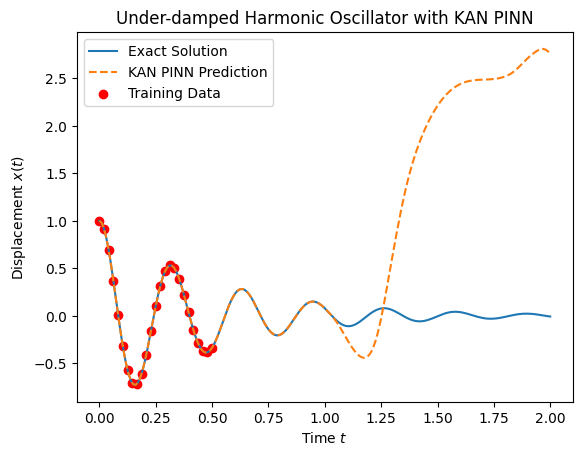

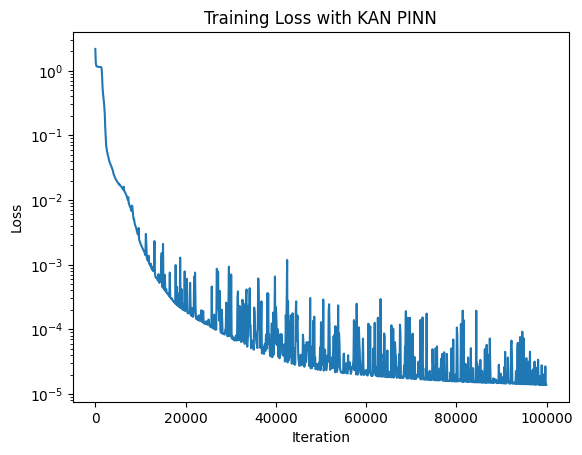

In [2]:
import numpy as np  # Original NumPy
import jax.numpy as jnp
from jax import random, grad, vmap, jit, value_and_grad
from jax.example_libraries import optimizers
from functools import partial
import matplotlib.pyplot as plt
from tqdm import trange
import itertools

# Import Flax modules
from flax import linen as nn

# Import the KAN model
from jaxkan.models.KAN import KAN


# Define the exact solution of the underdamped harmonic oscillator
def oscillator(d, w0, t):
    w = jnp.sqrt(w0 ** 2 - d ** 2)
    phi = jnp.arctan(-d / w)
    A = 1.0 / (2.0 * jnp.cos(phi))
    cos_term = jnp.cos(phi + w * t)
    exp_term = jnp.exp(-d * t)
    x = exp_term * 2 * A * cos_term
    return x

# Define the PINN model class using KAN
class PINN:
    def __init__(self, key, layers, mu, k):

        # Initialize the KAN model
        self.model = KAN(layer_dims=layers, add_bias=True)

        # Initialize parameters and state
        rng, init_rng = random.split(key)
        # Use a dummy ijnput to initialize the model
        x_init = jnp.array([[0.0]])  # Shape (1, 1)
        variables = self.model.init(init_rng, x_init)
        self.params = variables['params']
        self.state = variables.get('state', {})

        # Use optimizers to set optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=5000, decay_rate=0.90)
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(self.params)

        # Logger
        self.itercount = itertools.count()

        self.loss_log = []

        # Constants
        self.mu = mu
        self.k = k

    def net_apply(self, params, x):
        outputs, _ = self.model.apply({'params': params, 'state': self.state}, x)
        return outputs.squeeze()  # Ensure output is a scalar

    def neural_net(self, params):
        # Define a function that can be differentiated
        def net_fn(t):
            x = t.reshape(-1, 1)
            return self.net_apply(params, x)
        return net_fn

    def residual_net(self, params):
        net_fn = self.neural_net(params)
        def res_fn(t):
            x = net_fn(t)
            x_t = grad(net_fn)(t)
            x_tt = grad(grad(net_fn))(t)
            residual = x_tt + self.mu * x_t + self.k * x
            return residual
        return res_fn

    @partial(jit, static_argnums=(0,))
    def loss(self, params, t_r, t_data, x_data):
        # Residual loss
        res_fn = self.residual_net(params)
        res = vmap(res_fn)(t_r)
        res_squared = res ** 2

        # Compute attention weights based on residuals (optional)
        weights = res_squared / jnp.sum(res_squared)
        loss_res = jnp.sum(weights * res_squared)

        # Or use unweighted residual loss
        # loss_res = jnp.mean(res_squared)

        # Data loss (at observed data points)
        net_fn = self.neural_net(params)
        x_pred = vmap(net_fn)(t_data)
        loss_data = jnp.mean((x_pred - x_data) ** 2)

        # Initial condition loss
        x0_pred = net_fn(jnp.array(0.0))
        x0_t_pred = grad(net_fn)(jnp.array(0.0))
        loss_ic = (x0_pred - 1.0) ** 2 + (x0_t_pred - 0.0) ** 2

        # Total loss
        total_loss = 1.e-4*loss_res + loss_data + loss_ic

        return total_loss

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, t_r, t_data, x_data):
        params = self.get_params(opt_state)
        value, grads = value_and_grad(self.loss)(params, t_r, t_data, x_data)
        opt_state = self.opt_update(i, grads, opt_state)
        return opt_state, value

    def train(self, nIter, t_r, t_data, x_data):
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            self.current_count = next(self.itercount)
            self.opt_state, loss_value = self.step(self.current_count, self.opt_state, t_r, t_data, x_data)

            if it % 100 == 0:
                self.loss_log.append(loss_value)
                pbar.set_postfix({'Loss': loss_value})

# Constants for the underdamped harmonic oscillator
d = 2.0
w0 = 20.0
mu = 2 * d
k = w0 ** 2

# Generate collocation points and data points
t_r = jnp.linspace(0.0, 1.0, 100)          # Collocation points for residual
t_data = jnp.linspace(0.0, 0.5, 25)        # Data points for initial training
x_data = oscillator(d, w0, t_data)        # Exact solution at data points

# Initialize the model
key = random.PRNGKey(0)
layers = [1, 25, 25, 1]  # Adjust the layers as needed
model = PINN(key, layers, mu, k)

# Convert data to appropriate types
t_r = jnp.array(t_r)
t_data = jnp.array(t_data)
x_data = jnp.array(x_data)

# Train the model
model.train(nIter=100000, t_r=t_r, t_data=t_data, x_data=x_data)

# Evaluate the model
params = model.get_params(model.opt_state)
t_test = jnp.linspace(0.0, 2.0, 200)
t_test = jnp.array(t_test)
net_fn = model.neural_net(params)
x_pred = vmap(net_fn)(t_test)
x_exact = oscillator(d, w0, t_test)

# Plot the results
plt.figure()
plt.plot(t_test, x_exact, label='Exact Solution')
plt.plot(t_test, x_pred, '--', label='KAN PINN Prediction')
plt.scatter(t_data, x_data, color='red', label='Training Data')
plt.legend()
plt.xlabel('Time $t$')
plt.ylabel('Displacement $x(t)$')
plt.title('Under-damped Harmonic Oscillator with KAN PINN')
plt.show()

# Plot the training loss
plt.figure()
plt.plot(np.arange(len(model.loss_log))*100, model.loss_log)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training Loss with KAN PINN')
plt.show()


## ReLUKAN PINN

In [13]:



import numpy as np  # Original NumPy
import jax.numpy as jnp
from jax import random, grad, vmap, jit, value_and_grad
from jax.example_libraries import optimizers
from functools import partial
import matplotlib.pyplot as plt
from tqdm import trange
import itertools

# Import Flax modules
from flax import linen as nn

# Import the KAN model
from jaxkan.models.ReLUKAN import ReLUKAN


# Define the exact solution of the underdamped harmonic oscillator
def oscillator(d, w0, t):
    w = jnp.sqrt(w0 ** 2 - d ** 2)
    phi = jnp.arctan(-d / w)
    A = 1.0 / (2.0 * jnp.cos(phi))
    cos_term = jnp.cos(phi + w * t)
    exp_term = jnp.exp(-d * t)
    x = exp_term * 2 * A * cos_term
    return x

# Define the PINN model class using KAN
class PINN:
    def __init__(self, key, layers, mu, k):

        # Initialize the KAN model
        self.model = ReLUKAN(layer_dims=layers, add_bias=True)

        # Initialize parameters and state
        rng, init_rng = random.split(key)
        # Use a dummy ijnput to initialize the model
        x_init = jnp.array([[0.0]])  # Shape (1, 1)
        variables = self.model.init(init_rng, x_init)
        self.params = variables['params']
        self.state = variables.get('state', {})

        # Use optimizers to set optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=5000, decay_rate=0.90)
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(self.params)

        # Logger
        self.itercount = itertools.count()

        self.loss_log = []

        # Constants
        self.mu = mu
        self.k = k

    def net_apply(self, params, x):
        outputs, _ = self.model.apply({'params': params, 'state': self.state}, x)
        return outputs.squeeze()  # Ensure output is a scalar

    def neural_net(self, params):
        # Define a function that can be differentiated
        def net_fn(t):
            x = t.reshape(-1, 1)
            return self.net_apply(params, x)
        return net_fn

    def residual_net(self, params):
        net_fn = self.neural_net(params)
        def res_fn(t):
            x = net_fn(t)
            x_t = grad(net_fn)(t)
            x_tt = grad(grad(net_fn))(t)
            residual = x_tt + self.mu * x_t + self.k * x
            return residual
        return res_fn

    @partial(jit, static_argnums=(0,))
    def loss(self, params, t_r, t_data, x_data):
        # Residual loss
        res_fn = self.residual_net(params)
        res = vmap(res_fn)(t_r)
        res_squared = res ** 2

        # Compute attention weights based on residuals (optional)
        weights = res_squared / jnp.sum(res_squared)
        loss_res = jnp.sum(weights * res_squared)

        # Or use unweighted residual loss
        # loss_res = jnp.mean(res_squared)

        # Data loss (at observed data points)
        net_fn = self.neural_net(params)
        x_pred = vmap(net_fn)(t_data)
        loss_data = jnp.mean((x_pred - x_data) ** 2)

        # Initial condition loss
        x0_pred = net_fn(jnp.array(0.0))
        x0_t_pred = grad(net_fn)(jnp.array(0.0))
        loss_ic = (x0_pred - 1.0) ** 2 + (x0_t_pred - 0.0) ** 2

        # Total loss
        total_loss = 1.e-4*loss_res + loss_data + loss_ic

        return total_loss

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, t_r, t_data, x_data):
        params = self.get_params(opt_state)
        value, grads = value_and_grad(self.loss)(params, t_r, t_data, x_data)
        opt_state = self.opt_update(i, grads, opt_state)
        return opt_state, value

    def train(self, nIter, t_r, t_data, x_data):
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            self.current_count = next(self.itercount)
            self.opt_state, loss_value = self.step(self.current_count, self.opt_state, t_r, t_data, x_data)

            if it % 100 == 0:
                self.loss_log.append(loss_value)
                pbar.set_postfix({'Loss': loss_value})

# Constants for the underdamped harmonic oscillator
d = 2.0
w0 = 20.0
mu = 2 * d
k = w0 ** 2

# Generate collocation points and data points
t_r = jnp.linspace(0.0, 1.0, 100)          # Collocation points for residual
t_data = jnp.linspace(0.0, 0.5, 25)        # Data points for initial training
x_data = oscillator(d, w0, t_data)        # Exact solution at data points

# Initialize the model
key = random.PRNGKey(0)
layers = [1, 1024, 1]  # Adjust the layers as needed
model = PINN(key, layers, mu, k)

# Convert data to appropriate types
t_r = jnp.array(t_r)
t_data = jnp.array(t_data)
x_data = jnp.array(x_data)

# Train the model
model.train(nIter=10000000, t_r=t_r, t_data=t_data, x_data=x_data)

# Evaluate the model
params = model.get_params(model.opt_state)
t_test = jnp.linspace(0.0, 2.0, 200)
t_test = jnp.array(t_test)
net_fn = model.neural_net(params)
x_pred = vmap(net_fn)(t_test)
x_exact = oscillator(d, w0, t_test)

# Plot the results
plt.figure()
plt.plot(t_test, x_exact, label='Exact Solution')
plt.plot(t_test, x_pred, '--', label='KAN PINN Prediction')
plt.scatter(t_data, x_data, color='red', label='Training Data')
plt.legend()
plt.xlabel('Time $t$')
plt.ylabel('Displacement $x(t)$')
plt.title('Under-damped Harmonic Oscillator with KAN PINN')
plt.show()

# Plot the training loss
plt.figure()
plt.plot(np.arange(len(model.loss_log))*100, model.loss_log)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training Loss with KAN PINN')
plt.show()


  1%|          | 67676/10000000 [01:34<3:50:18, 718.75it/s, Loss=0.019916419]


KeyboardInterrupt: 

# High-level implementation

In [12]:
import numpy as np  # Original NumPy
import jax
import jax.numpy as jjnp
from jax import random, grad, vmap
import matplotlib.pyplot as plt
from tqdm import trange
import time

# Import Flax modules
from flax import linen as nn

# Import the KAN model
from jaxkan.models.KAN import KAN

# Import PIKAN functions (assuming PIKAN.py is in the same directory or installed as a module)
from jaxkan.utils.PIKAN import (
    gradf,  # Use the modified gradf function provided below
    get_vanilla_loss,
    get_adapt_loss,
    train_PIKAN,
    sobol_sample,
    interpolate_moments,
    state_transition,
)

# Define constants for the underdamped harmonic oscillator
d = 2.0
w0 = 20.0
mu = 2 * d
k = w0 ** 2
m = 1.0  # Assuming mass m = 1.0

# Define the exact solution function
def oscillator(d, w0, t):
    w = jjnp.sqrt(w0 ** 2 - d ** 2)
    phi = jjnp.arctan(-d / w)
    A = 1.0 / (2.0 * jjnp.cos(phi))
    cos_term = jjnp.cos(phi + w * t)
    exp_term = jjnp.exp(-d * t)
    x = exp_term * 2 * A * cos_term
    return x

# Modified gradf function for scalar functions
def gradf(f, order=1):
    '''
        Computes derivatives of arbitrary order for scalar functions of scalar ijnput.

        Args:
            f (function): function to be differentiated, scalar ijnput and scalar output
            order (int): derivative order

        Returns:
            g (function): derivative of f of specified order
    '''
    g = f
    for _ in range(order):
        g = jax.grad(g)
    return g

# Define the PDE loss function
def harmonic_oscillator_pde_loss(params, collocs, state):
    # collocs shape: (N_colloc, 1) for 1D ijnput (time)
    t = collocs[:, 0]  # Extract time points

    # Define the model function
    variables = {'params': params, 'state': state}

    def net_fn(t_scalar):
        x_ijnput = jjnp.array([[t_scalar]])  # Ensure x_ijnput has shape (1, n_in)
        y, _ = model.apply(variables, x_ijnput)
        return y.squeeze()

    # Compute the network predictions
    x = vmap(net_fn)(t)

    # Compute first and second derivatives with respect to time
    x_t = vmap(jax.grad(net_fn))(t)
    x_tt = vmap(gradf(net_fn, order=2))(t)

    # Compute the residuals of the ODE
    residuals = x_tt + mu * x_t + k * x

    return residuals.reshape(-1, 1)  # Ensure the residuals have shape (N_colloc, 1)

# Generate collocation points
N_colloc = 1000
t_min, t_max = 0.0, 2.0
collocs = jjnp.array(sobol_sample(np.array([t_min]), np.array([t_max]), N_colloc))

# Boundary collocation points (initial conditions)
bc_collocs = [
    jjnp.array([[0.0]]),  # For x(0)
    jjnp.array([[0.0]]),  # For dx/dt(0)
]

# Corresponding boundary data
bc_data = [
    jjnp.array([[1.0]]),  # x(0) = 1
    jjnp.array([[0.0]]),  # dx/dt(0) = 0
]

# Define the KAN model layer dimensions
layers = [1, 50, 50, 1]  # Adjust as needed

# Initialize the model
key = random.PRNGKey(0)
model = ReLUKAN(layer_dims=layers, add_bias=True)

# Initialize model variables
rng, init_rng = random.split(key)
x_init = jjnp.array([[0.0]])  # Dummy ijnput for initialization
variables = model.init(init_rng, x_init)

# Global weights for loss terms: [PDE loss weight, BC1 weight, BC2 weight]
glob_w = [1.0, 100.0, 100.0]  # Adjust weights as needed

# Learning rate scheduler parameters
lr_vals = {
    'init_lr': 1e-3,
    'scales': {1000: 0.5, 2000: 0.1},  # Learning rate decays at epochs 1000 and 2000
}

# Number of training epochs
num_epochs = 5000

# Whether to use adaptive loss weighting (RBA)
use_adaptive_loss = True  # Set True if you want to use RBA

# Local weights for adaptive loss (initialize to ones)
if use_adaptive_loss:
    loc_w = [
        jjnp.ones((N_colloc, 1)),  # For PDE residuals
        jjnp.ones((1, 1)),         # For x(0)
        jjnp.ones((1, 1)),         # For dx/dt(0)
    ]
else:
    loc_w = None

# Grid extension epochs and new grid sizes
grid_extend = {
    0: 3,  # At epoch 0, set grid size G_val = 3
}

# Grid adaptation epochs (if needed)
grid_adapt = []

# Collocation adaptation parameters (if needed)
colloc_adapt = {
    'epochs': [],  # List of epochs at which to resample collocation points
    'M': 2000,     # Number of points for resampling
    'k': 1.0,      # Parameter for RDA
    'c': 1.0,      # Parameter for RDA
}

# Train the model
model, variables, train_losses = train_PIKAN(
    model=model,
    variables=variables,
    pde_loss=harmonic_oscillator_pde_loss,
    collocs=collocs,
    bc_collocs=bc_collocs,
    bc_data=bc_data,
    glob_w=glob_w,
    lr_vals=lr_vals,
    adapt_state=True,
    loc_w=loc_w,
    nesterov=True,
    num_epochs=num_epochs,
    grid_extend=grid_extend,
    grid_adapt=grid_adapt,
    colloc_adapt=colloc_adapt
)

# Generate test points
t_test = jjnp.linspace(t_min, t_max, 200).reshape(-1)

# Define the model function using the trained variables
def net_fn(t_scalar):
    x_ijnput = jjnp.array([[t_scalar]])  # Ensure x_ijnput has shape (1, n_in)
    y, _ = model.apply(variables, x_ijnput)
    return y.squeeze()

# Compute predictions
x_pred = vmap(net_fn)(t_test)

# Compute exact solution
x_exact = oscillator(d, w0, t_test)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_test, x_exact, label='Exact Solution')
plt.plot(t_test, x_pred, '--', label='PIKAN Prediction')
plt.scatter(bc_collocs[0], bc_data[0], color='red', label='Training Data (IC)')
plt.legend()
plt.xlabel('Time $t$')
plt.ylabel('Displacement $x(t)$')
plt.title('Under-damped Harmonic Oscillator with PIKAN')
plt.show()

# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(np.arange(num_epochs), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training Loss with PIKAN')
plt.show()


Epoch 0: Performing grid update



KeyboardInterrupt



# Progress study

In [7]:
# -------------------------------------------------------------
# Imports
# -------------------------------------------------------------

import numpy as np  # Original NumPy
import jax.numpy as jnp
from jax import random, grad, vmap, jit, value_and_grad
from jax.example_libraries import optimizers
from jax.flatten_util import ravel_pytree
from functools import partial
import matplotlib.pyplot as plt
from tqdm import trange
import itertools
import pandas as pd

# -------------------------------------------------------------
# Define the exact solution of the underdamped harmonic oscillator
# -------------------------------------------------------------

def oscillator(d, w0, t):
    w = jnp.sqrt(w0 ** 2 - d ** 2)
    phi = jnp.arctan(-d / w)
    A = 1.0 / (2.0 * jnp.cos(phi))
    cos_term = jnp.cos(phi + w * t)
    exp_term = jnp.exp(-d * t)
    x = exp_term * 2 * A * cos_term
    return x

# -------------------------------------------------------------
# Define the MLP function
# -------------------------------------------------------------

def MLP(layers, activation=jnp.tanh):
    def init(rng_key):
        def init_layer(key, d_in, d_out):
            k1, _ = random.split(key)
            glorot_stddev = 1.0 / jnp.sqrt((d_in + d_out) / 2.)
            W = glorot_stddev * random.normal(k1, (d_in, d_out))
            b = jnp.zeros(d_out)
            return W, b
        keys = random.split(rng_key, len(layers))
        params = list(map(init_layer, keys, layers[:-1], layers[1:]))
        return params

    def apply(params, inputs):
        H = inputs
        for W, b in params[:-1]:
            outputs = jnp.dot(H, W) + b
            H = activation(outputs)
        W, b = params[-1]
        outputs = jnp.dot(H, W) + b
        return outputs

    return init, apply

# -------------------------------------------------------------
# Define the PINN model class with time-dependent weighting
# -------------------------------------------------------------

class PINN:
    def __init__(self, key, layers, mu, k, activation, lambda_decay):

        # Initialize the neural network
        self.init, self.apply = MLP(layers, activation=activation)
        params = self.init(rng_key=key)
        _, self.unravel = ravel_pytree(params)

        # Use optimizers to set optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=5000, decay_rate=0.90)
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []

        # Constants
        self.mu = mu
        self.k = k

        # Decay rate for time-dependent weighting
        self.lambda_decay = lambda_decay  # Adjusted as a hyperparameter

    def neural_net(self, params):
        def net_apply(t):
            outputs = self.apply(params, t.reshape(-1, 1))
            return outputs.squeeze()  # Ensure output is a scalar
        return net_apply

    def residual_net(self, params):
        net_apply = self.neural_net(params)
        def res_apply(t):
            x = net_apply(t)
            x_t = grad(net_apply)(t)
            x_tt = grad(grad(net_apply))(t)
            residual = x_tt + self.mu * x_t + self.k * x
            return residual
        return res_apply

    @partial(jit, static_argnums=(0,))
    def loss(self, params, t_r, t_data, x_data):
        # Residual loss with time-dependent weighting
        res_apply = self.residual_net(params)
        residual_fn = vmap(res_apply)
        res = residual_fn(t_r)
        res_squared = res ** 2

        # Time-dependent weights
        weights_time = jnp.exp(-self.lambda_decay * t_r)
        weights_time /= jnp.sum(weights_time)  # Normalize weights

        # Apply weights to residual loss
        loss_res = jnp.sum(weights_time * res_squared)

        # Data loss (at observed data points)
        net_apply = self.neural_net(params)
        x_pred = vmap(net_apply)(t_data)
        loss_data = jnp.mean((x_pred - x_data) ** 2)

        # Initial condition loss
        x0_pred = net_apply(jnp.array(0.0))
        x0_t_pred = grad(net_apply)(jnp.array(0.0))
        loss_ic = (x0_pred - 1.0) ** 2 + (x0_t_pred - 0.0) ** 2

        # Total loss
        total_loss = 1.e-4 * loss_res + loss_data + loss_ic

        return total_loss

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, t_r, t_data, x_data):
        params = self.get_params(opt_state)
        value, grads = value_and_grad(self.loss)(params, t_r, t_data, x_data)
        opt_state = self.opt_update(i, grads, opt_state)
        return opt_state, value

    def train(self, nIter, t_r, t_data, x_data):
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            self.current_count = next(self.itercount)
            self.opt_state, loss_value = self.step(self.current_count, self.opt_state, t_r, t_data, x_data)

            if it % 100 == 0:
                self.loss_log.append(loss_value)
                pbar.set_postfix({'Loss': loss_value})

# -------------------------------------------------------------
# Constants for the underdamped harmonic oscillator
# -------------------------------------------------------------

d = 2.0
w0 = 20.0
mu = 2 * d
k = w0 ** 2

# -------------------------------------------------------------
# Experiment Setup
# -------------------------------------------------------------

# Define the number of experiments
NUM_EXPERIMENTS = 50  # Adjust as needed
LAYERS = [1, 256, 256, 256, 256, 1]  # Number of neurons in each layer
ACTIVATION_FUNCTION = jax.nn.gelu  # Activation function for the neural network
TIME_DECAY = 0.1  # Decay rate for time-dependent weighting

# Define hyperparameter ranges
LAMBDA_DECAY_RANGE = (0.1, 5.0)  # Decay rate for time-dependent weighting
NOISE_LEVEL_RANGE = (0.0, 0.1)  # Noise level in data
TRAINING_EPOCHS = 10000  # Number of training iterations

# Initialize a list to store results
experiment_results = []

# Set up collocation points and data points (same for all experiments)
t_r = jnp.linspace(0.0, 1.0, 100)          # Collocation points for residual
t_data = jnp.linspace(0.0, 0.5, 25)        # Data points for initial training
x_data_exact = oscillator(d, w0, t_data)   # Exact solution at data points

# Convert data to appropriate types
t_r = jnp.array(t_r)
t_data = jnp.array(t_data)
x_data_exact = jnp.array(x_data_exact)

# Optionally, add noise to data
def add_noise(x, noise_level, key):
    key, subkey = random.split(key)
    noise = noise_level * random.normal(subkey, shape=x.shape)
    return x + noise

# Experimental loop
for exp_num in range(NUM_EXPERIMENTS):
    print(f"\nStarting experiment {exp_num + 1}/{NUM_EXPERIMENTS}")

    # Random key for this experiment
    key = random.PRNGKey(exp_num)
    keys = random.split(key, 5)

    # Sample hyperparameters
    noise_level_exp = random.uniform(keys[4], minval=NOISE_LEVEL_RANGE[0], maxval=NOISE_LEVEL_RANGE[1])

    # Add noise to data if noise_level_exp > 0
    x_data = add_noise(x_data_exact, noise_level_exp, key)

    # Initialize the model
    model_key = random.PRNGKey(exp_num + 1000)  # Different key for model initialization
    model = PINN(
        key=model_key,
        layers=LAYERS,
        mu=mu,
        k=k,
        activation=ACTIVATION_FUNCTION,
        lambda_decay=TIME_DECAY
    )

    # Train the model
    model.train(nIter=TRAINING_EPOCHS, t_r=t_r, t_data=t_data, x_data=x_data)

    # Evaluate the model
    params = model.get_params(model.opt_state)
    t_test = jnp.linspace(0.0, 2.0, 200)
    t_test = jnp.array(t_test)
    net_apply = model.neural_net(params)
    x_pred = vmap(net_apply)(t_test)
    x_exact = oscillator(d, w0, t_test)

    # Compute Mean Squared Error (MSE) over the test range
    mse = float(jnp.mean((x_exact - x_pred) ** 2))

    # Store results
    experiment_results.append({
        'Noise_Level': float(noise_level_exp),
        'MSE': mse
    })

    print(f"Experiment {exp_num + 1} completed. MSE: {mse}")

# Convert results to a DataFrame
results_df = pd.DataFrame(experiment_results)
print(results_df)

# -------------------------------------------------------------
# Statistical Analysis (Optional)
# -------------------------------------------------------------

# For example, perform a linear regression to see the effect of hyperparameters on MSE
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Prepare the DataFrame for regression analysis
# Map activation functions to strings
results_df['Activation_Function'] = results_df['Activation_Function'].astype(str)

# Encode categorical variables
results_df_encoded = pd.get_dummies(results_df, columns=['Activation_Function'], drop_first=True)

# Log-transform MSE for better linearity
results_df_encoded['log_MSE'] = np.log(results_df_encoded['MSE'])

# Define the regression formula
formula = 'log_MSE ~ Layer_Size + Num_Hidden_Layers + Lambda_Decay + Noise_Level + Activation_Function_jax_nn_relu + Activation_Function_jax_nn_gelu'

# Fit the model
model = ols(formula, data=results_df_encoded).fit()

# Print the regression results
print(model.summary())



Starting experiment 1/50


100%|██████████| 10000/10000 [00:08<00:00, 1139.55it/s, Loss=0.00279316]  


Experiment 1 completed. MSE: 0.42326101660728455

Starting experiment 2/50


100%|██████████| 10000/10000 [00:07<00:00, 1363.57it/s, Loss=0.049513742]


Experiment 2 completed. MSE: 0.13694699108600616

Starting experiment 3/50


100%|██████████| 10000/10000 [00:07<00:00, 1330.97it/s, Loss=0.00076211104]


Experiment 3 completed. MSE: 0.8128791451454163

Starting experiment 4/50


100%|██████████| 10000/10000 [00:07<00:00, 1309.01it/s, Loss=0.005471059]


Experiment 4 completed. MSE: 0.12543949484825134

Starting experiment 5/50


  0%|          | 0/10000 [00:03<?, ?it/s]


KeyboardInterrupt: 

# chat gpt question formulation

ok great now lets upgrade our implementation. bellow are the contents of a file called PIKAN.py (referring to physics-informed (PI) KAN)

```python
import jax
import jax.numpy as jjnp
from jax import vmap

import optax
from flax import linen as nn

from scipy.stats.qmc import Sobol
import numpy as jnp

import time


def interpolate_moments(mu_old, nu_old, new_shape):
    '''
        Performs a linear interpolation to assign values to the first and second-order moments of gradients
        of the c_i basis functions coefficients after grid extension
        Note:
            num_basis = G+k for splines and G+1 for R basis functions
            new_num_basis = G'+k for splines and G'+1 for R basis functions
        
        Args:
        -----
            mu_old (jjnp.array): first-order moments before extension
                shape (n_in*n_out, num_basis)
            nu_old (jjnp.array): second-order moments before extension
                shape (n_in*n_out, num_basis)
            new shape (tuple): (n_in*n_out, new_num_basis)
        
        Returns:
        --------
            mu_new (jjnp.array): first-order moments after extension
                shape (n_in*n_out, new_num_basis)
            nu_new (jjnp.array): second-order moments after extension
                shape (n_in*n_out, new_num_basis)
    '''
    old_shape = mu_old.shape
    size = old_shape[0]
    old_j = old_shape[1]
    new_j = new_shape[1]
    
    # Create new indices for the second dimension
    old_indices = jjnp.linspace(0, old_j - 1, old_j)
    new_indices = jjnp.linspace(0, old_j - 1, new_j)

    # Vectorize the interpolation function for use with vmap
    interpolate_fn = lambda old_row: jjnp.interp(new_indices, old_indices, old_row)

    # Apply the interpolation function to each row using vmap
    mu_new = vmap(interpolate_fn)(mu_old)
    nu_new = vmap(interpolate_fn)(nu_old)
    
    return mu_new, nu_new


@jax.jit
def state_transition(old_state, variables):
    '''
        Performs the state transition for the optimizer after grid extension
        
        Args:
        -----
            old_state (tuple): collection of adam state and scheduler state before extension
            variables (dict): variables dict of KAN model
        
        Returns:
        --------
            new_state (tuple): collection of adam state and scheduler state after extension
    '''
    # Copy old state
    adam_count = old_state[0].count
    #adam_count = jjnp.array(0, dtype=jjnp.int32)
    adam_mu, adam_nu = old_state[0].mu, old_state[0].nu

    # Get all layer-related keys, so that we do not touch the other parameters
    layer_keys = {k for k in adam_mu.keys() if k.startswith('layers_')}

    for key in layer_keys:
        # Find the c_basis shape for this layer
        c_shape = variables['params'][key]['c_basis'].shape
        # Get new mu and nu
        mu_new, nu_new = interpolate_moments(adam_mu[key]['c_basis'], adam_nu[key]['c_basis'], c_shape)
        # Set them
        adam_mu[key]['c_basis'], adam_nu[key]['c_basis'] = mu_new, nu_new

    # Make new adam state
    adam_state = optax.ScaleByAdamState(adam_count, adam_mu, adam_nu)
    # Make new scheduler state
    extra_state = optax.ScaleByScheduleState(adam_count)
    # Make new total state
    new_state = (adam_state, extra_state)

    return new_state


def sobol_sample(X0, X1, N, seed=42):
    '''
        Performs Sobol sampling
        
        Args:
        -----
            X0 (jnp.ndarray): lower end of sampling region
                shape (dims,)
            X1 (jnp.ndarray): upper end of sampling region
                shape (dims,)
            N (int): number of points to sample
            seed (int): seed for reproducibility
        
        Returns:
        --------
            points (jnp.ndarray): sampled points
                shape (N,dims)
    '''
    dims = X0.shape[0]
    sobol_sampler = Sobol(dims, scramble=True, seed=seed)
    points = sobol_sampler.random_base2(int(jnp.log2(N)))
    points = X0 + points * (X1 - X0)
    
    return points


def gradf(f, idx, order=1):
    '''
        Computes gradients of arbitrary order
        
        Args:
        -----
            f (function): function to be differentiated
            idx (int): index of coordinate to differentiate
            order (int): gradient order
        
        Returns:
        --------
            g (function): gradient of f
    '''
    def grad_fn(g, idx):
        return lambda tx: jax.grad(lambda tx: jjnp.sum(g(tx)))(tx)[..., idx].reshape(-1,1)

    g = lambda tx: f(tx)
    
    for _ in range(order):
        g = grad_fn(g, idx)
        
    return g


def get_vanilla_loss(pde_loss, model, variables):
    '''
        Wrapper that returns the loss function for a vanilla PIKAN
        
        Args:
        -----
            pde_loss (function): loss function corresponding to the PDE
            model: model from the models module
            variables (dict): variables dict of KAN model
        
        Returns:
        --------
            vanilla_loss_fn (function): loss function for the PIKAN
    '''
    
    @jax.jit
    def vanilla_loss_fn(params, collocs, bc_collocs, bc_data, glob_w, loc_w, state):
        '''
            Loss function for a vanilla PIKAN
            
            Args:
            -----
                params (dict): trainable parameters of the model
                collocs (jjnp.array): collocation points for the PDE loss
                bc_collocs (List[jjnp.array]): list of collocation points for the boundary losses
                bc_data (List[jjnp.array]): list of data corresponding to bc_collocs
                glob_w (List[jjnp.array]): global weights for each loss function's term
                loc_w (NoneType): placeholder to ensure a uniform train_step()
                state (dict): non-trainable parameters of the model
                
            Returns:
            --------
                total_loss (float): the loss function's value
                None (NoneType): placeholder to ensure a uniform train_step()
        '''     
        # Calculate PDE loss
        pde_res = pde_loss(params, collocs, state)
        total_loss = glob_w[0]*jjnp.mean((pde_res)**2)
        
        # Define the model function
        variables = {'params' : params, 'state' : state}
        
        def u(vec_x):
            y, spl = model.apply(variables, vec_x)
            return y
            
        # Boundary Losses
        for idx, colloc in enumerate(bc_collocs):
            # Residual = Model's prediction - Ground Truth
            residual = u(colloc) - bc_data[idx]
            # Loss
            total_loss += glob_w[idx+1]*jjnp.mean((residual)**2)

        # return a tuple to be the same as adaptive_loss_fn and thus be able
        # to define a common train step
        return total_loss, None
        
    return vanilla_loss_fn


def get_adapt_loss(pde_loss, model, variables):
    '''
        Wrapper that returns the loss function for an adaptive PIKAN
        
        Args:
        -----
            pde_loss (function): loss function corresponding to the PDE
            model: model from the models module
            variables (dict): variables dict of KAN model
        
        Returns:
        --------
            adaptive_loss_fn (function): loss function for the PIKAN
    '''
    
    @jax.jit
    def adaptive_loss_fn(params, collocs, bc_collocs, bc_data, glob_w, loc_w, state):
        '''
            Loss function for an adaptive PIKAN
            
            Args:
            -----
                params (dict): trainable parameters of the model
                collocs (jjnp.array): collocation points for the PDE loss
                bc_collocs (List[jjnp.array]): list of collocation points for the boundary losses
                bc_data (List[jjnp.array]): list of data corresponding to bc_collocs
                glob_w (List[jjnp.array]): global weights for each loss function's term
                loc_w (List[jjnp.array]): local RBA weights for each loss function's term
                state (dict): non-trainable parameters of the model
                
            Returns:
            --------
                total_loss (float): the loss function's value
                loc_w (List[jjnp.array]): updated RBA weights based on residuals
        '''
        # Loss parameter
        eta = jjnp.array(0.0001, dtype=float)
        # Placeholder list for RBA weights
        new_loc_w = []
    
        # Calculate PDE loss
        pde_res = pde_loss(params, collocs, state)
        
        # New RBA weights
        abs_res = jjnp.abs(pde_res)
        loc_w_pde = ((jjnp.array(1.0)-eta)*loc_w[0]) + ((eta*abs_res)/jjnp.max(abs_res))
        new_loc_w.append(loc_w_pde)
        
        # Weighted Loss
        total_loss = glob_w[0]*jjnp.mean((loc_w_pde*pde_res)**2)
    
        # Define the model function
        variables = {'params' : params, 'state' : state}
        
        def u(vec_x):
            y, spl = model.apply(variables, vec_x)
            return y
    
        # Boundary Losses
        for idx, colloc in enumerate(bc_collocs):
            # Residual = Model's prediction - Ground Truth
            bc_res = u(colloc) - bc_data[idx]
            # New RBA weight
            abs_res = jjnp.abs(bc_res)
            loc_w_bc = ((jjnp.array(1.0)-eta)*loc_w[idx+1]) + ((eta*abs_res)/jjnp.max(abs_res))
            new_loc_w.append(loc_w_bc)
            # Weighted Loss
            total_loss += glob_w[idx+1]*jjnp.mean((loc_w_bc*bc_res)**2)
    
        return total_loss, new_loc_w

    return adaptive_loss_fn


def train_PIKAN(model, variables, pde_loss, collocs, bc_collocs, bc_data, glob_w, lr_vals, 
                adapt_state=True, loc_w=None, nesterov=True, num_epochs = 3001, grid_extend={0 : 3}, grid_adapt=[], colloc_adapt={'epochs':[], 'M':1000, 'k':1.0, 'c':1.0}):
    '''
        Training routine for a PIKAN
        
        Args:
        -----
            model: model from the models module
            variables (dict): dict containing the params and state dicts
            pde_loss (function): loss function corresponding to the PDE
            collocs (jjnp.array): collocation points for the PDE loss
            bc_collocs (List[jjnp.array]): list of collocation points for the boundary losses
            bc_data (List[jjnp.array]): list of data corresponding to bc_collocs
            glob_w (List[jjnp.array]): global weights for each loss function's term
            lr_vals (dict): dict containing information about the scheduler
            adapt_state (bool): boolean that determines if adaptive state transition is applied during grid extension
            loc_w (List[jjnp.array]): local RBA weights for each loss function's term
            nesterov (bool): boolean that determines if Nesterov momentum is used for Adam
            num_epochs (int): number of training epochs
            grid_extend (dict): dict of epochs during which to perform grid extension and new values of G
            grid_adapt (List): list of epochs during which to perform grid adaptation
            colloc_adapt (dict): dict containing information about the RDA method
            
        Returns:
        --------
            model: trained model
            variables (dict): dict containing the params and state dicts of the trained model
            train_losses (jjnp.array): values of the loss function per epoch
                shape (num_epochs,)
    '''
    # Setup scheduler for optimizer
    scheduler = optax.piecewise_constant_schedule(
        init_value=lr_vals['init_lr'],
        boundaries_and_scales=lr_vals['scales']
    )
    # Initialize optimizer
    optimizer = optax.adam(learning_rate=scheduler, nesterov=nesterov)
    # Initialize optimizer state
    opt_state = optimizer.init(variables['params'])

    # Define loss function
    if loc_w is None:
        loss_fn = get_vanilla_loss(pde_loss, model, variables)
    else:
        loss_fn = get_adapt_loss(pde_loss, model, variables)

    # Define train loop
    @jax.jit
    def train_step(params, opt_state, collocs, bc_collocs, bc_data, glob_w, loc_w, state):
        
        (loss, loc_w), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, collocs, bc_collocs, bc_data, glob_w, loc_w, state)
        
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        
        new_variables = {'params': params, 'state': state}
        
        return new_variables, opt_state, loss, loc_w

    # Check if we perform adaptive collocation points resampling
    if colloc_adapt['epochs']:
        # Define the function
        @jax.jit
        def resample_collocs(variables, collocs, sample, k=jjnp.array(1.0), c=jjnp.array(1.0)):
            # Calculate residuals of PDE
            resids = jjnp.abs(pde_loss(variables['params'], sample, variables['state']))
            # Raise to power k
            ek = jjnp.power(resids, k)
            # Divide by mean and add c
            px = (ek/jjnp.mean(ek)) + c
            # Normalize
            px_norm = (px / jjnp.sum(px))[:,0]
            # Draw ids for the sampled points using px_norm
            # Note that they key can be added as a function argument, for now there's no reason to
            X_ids = jax.random.choice(key=jax.random.PRNGKey(0), a=sample.shape[0], shape=(collocs.shape[0],), replace=False, p=px_norm)
            # Replace collocation points
            new_collocs = sample[X_ids]
        
            return new_collocs
    
        # Sample M points from Sobol
        M = colloc_adapt['M']
        sample = jjnp.array(sobol_sample(jnp.array([0,-1]), jnp.array([1,1]), M))
        # Draw k, c hyperparameters
        k, c = colloc_adapt['k'], colloc_adapt['c']

    # Initialize train_losses
    train_losses = jjnp.zeros((num_epochs,))

    # Start training
    start_time=time.time()
    G_val = grid_extend[0]
    
    for epoch in range(num_epochs):
        # Check if we have to adapt collocation points
        if epoch in colloc_adapt['epochs']:
            # Get new colloc points
            collocs = resample_collocs(variables, collocs, sample, k, c)
            # Restart training loc_w for the PDE if we're doing RBA
            if loc_w is not None:
                new_loc_w = jjnp.full_like(loc_w[0], jjnp.mean(loc_w[0]))
                loc_w[0] = new_loc_w
            # Adapt grid to new collocation points
            updated_variables = model.apply(variables, collocs, G_val, method=model.update_grids)
            variables = updated_variables.copy()
        # Check if we're in an update epoch
        if epoch in grid_adapt:
            updated_variables = model.apply(variables, collocs, G_val, method=model.update_grids)
            variables = updated_variables.copy()
        # Check if we're in an extension epoch
        if epoch in grid_extend.keys():
            print(f"Epoch {epoch}: Performing grid update")
            # Get grid size
            G_val = grid_extend[epoch]
            # Perform the update
            updated_variables = model.apply(variables, collocs, G_val, method=model.update_grids)
            variables = updated_variables.copy()
            # Optimizer Transition
            if adapt_state:
                opt_state = state_transition(opt_state, variables)
            else:
                opt_state = optimizer.init(variables['params'])
            
        # Calculate the loss
        params, state = variables['params'], variables['state']
        variables, opt_state, loss, loc_w  = train_step(params, opt_state, collocs, bc_collocs, bc_data, glob_w, loc_w, state)

        # Append the loss
        train_losses = train_losses.at[epoch].set(loss)

    # Calculate training time
    end_time = time.time()
    elapsed = end_time-start_time
    print(f"Total Time: {elapsed} s")
    print(f"Average time per iteration: {elapsed/num_epochs:.4f} s")
    
    return model, variables, train_losses
```
please restructure the harmonic oscillator code to be compatible for this PIKAN framework